In [1]:
%load_ext autoreload
%autoreload 2

from keras.datasets.mnist import load_data
import numpy as np
import torch
from scipy.special import logit
from torch.utils.data import TensorDataset, DataLoader

from core.mades import MADE_MOG
from core.mafs import MAF
import torch.optim as optim
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [2]:
def dequantize_and_rescale(x):
    """Assuming that x is from 0 to 255"""
    x = (x + np.random.uniform(0, 1, size=x.shape)) / 256
    lamb = 1e-6
    return logit(lamb + (1 - 2 * lamb) * x)

In [3]:
(x_train, _), (x_test, _) = load_data()

print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

x_train = dequantize_and_rescale(x_train)
x_test = dequantize_and_rescale(x_test)

print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

x_train = torch.from_numpy(x_train.reshape(-1, 784))
x_test = torch.from_numpy(x_test.reshape(-1, 784))

train_ds = TensorDataset(x_train)
test_ds = TensorDataset(x_test)

train_dl = DataLoader(train_ds, batch_size=100)
test_dl = DataLoader(test_ds, batch_size=100)

0 255
0 255
-13.815449671006862 13.802135428374841
-13.814064986756714 13.81274926632853


In [4]:
dist = MADE_MOG(data_dim=28*28, hidden_dims=[1024, 1024], num_components=10)

In [17]:
# opt = optim.Adam(dist.parameters(), lr=1e-3)

# for i in range(100):

#     losses_batch = []

#     for (xb, ) in tqdm(train_dl):

#         loss = -dist.log_prob(xb.float()).mean()

#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         losses_batch.append(float(loss))

#     print(i+1, np.mean(losses_batch))
    
#     with torch.no_grad():
        
#         losses_batch = []
        
#         for (xb, ) in tqdm(test_dl):

#             loss = -dist.log_prob(xb.float()).mean()

#             losses_batch.append(float(loss))
            
#         print(i+1, np.mean(losses_batch))

# torch.save(dist.state_dict(), "./saved/mnist_density_estimation/mnist_made_mog.pth")

In [19]:
dist.load_state_dict(torch.load("./saved/mnist_density_estimation/mnist_made_mog.pth"))

<All keys matched successfully>

In [12]:
samples = dist.sample(100)

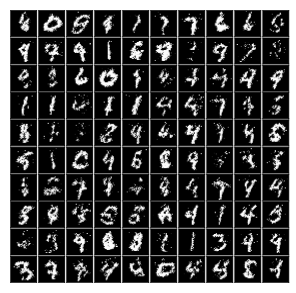

In [16]:
nrows, ncols = 10, 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))

lamb = 1e-6

for i in range(nrows):
    for j in range(ncols):

        axes[i][j].matshow(
            (torch.sigmoid(samples[i*ncols+j].reshape(28, 28)) - lamb)/(1 - 2 * lamb), cmap="gray", vmin=0, vmax=1
        )
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    
plt.subplots_adjust(wspace=0.05, hspace=0.05) 
plt.savefig("./saved/mnist_density_estimation/mnist_gen.png", dpi=500)